<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Exploring overland flow routing with Landlab

To swiftly develop experiments using community resources is an extraordinary emerging opportunity to accelerate the rate of scientific advancement.The ability to test hypotheses about hydrology, geomorphology and atmospheric processes is invaluable to research in the Earth and planetary sciences; using cyber-infrastructure that allows formal publication and sharing of data and model online is an emerging approach in many research communities. 

**Science activities**
* Introduce Shallow Water Equation, Test Area, Model Steps, and Curriculum Questions. <br />
* Use Landlab to set up a comparative model experiment.
* Run a Landlab model.<br />
* Explore flow sensitivity.
* Save results to a new HydroShare resource.  <br />
<br />

**Data Science and Cyberinfrastructure**

This notebook is a computational narrative using the [Landlab](http://landlab.github.io) Python-based modeling environment that allows scientists and students to build numerical landscape models.
This work also utilized the following open source research software libraries: numpy, matplotlib, pandas, and hydroshare. The software environment is provided by the [CUAHSI JupyterHub server](https://jupyter.cuahsi.org). 

_To run this notebook:_

Click in each shaded code block below and use "shift + enter" keys. Alternatively, you can run groups of cells by clicking "Cell" on the menu above and selecting among the various run options. This is also where you can clear outputs from previous runs.

Every time you run this notebook the model outputs you generated are saved in your personal user space in the virtual computer through Hydroshare. These outputs are available for you to plot and explore the models using the plotting functions at the end of this tutorial. 

Your final results can be saved to Hydroshare, see section 5.0 below.
Unwanted model output can be deleted at anytime from your space. For this run the last code block of this tutorial. 

If an error occurs, click on *Kernal* and *Restart and Clear Outputs* in the menu above.
<hr> <small> For more instructions on how to run an interactive IPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>

**Acknowledgements**

This notebook was developed from code written by Jordan Adams as part of her PhD disseration at Tulane University and Amanda Manaster as a tutorial for a Landlab workshop at the Geophysical Society of America Annual Meeting, Seattle, WA, 2018. Nathan Lyons provided code and technical support on animations.   

Use or citation of this notebook should also reference: Adams, J. M., Gasparini, N. M., Hobley, D. E. J., Tucker, G. E., Hutton, E. W. H., Nudurupati, S. S., and Istanbulluoglu, E.: The Landlab v1.0 OverlandFlow component: a Python tool for computing shallow-water flow across watersheds, Geosci. Model Dev., 10, 1645-1663, https://doi.org/10.5194/gmd-10-1645-2017, 2017.


<small>For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>

## 1.0. Introduction

### 1.1. Theory

The 1-D Saint Venant equation for transient shallow water flow is in the core of most hydrodynamics models:

$$ \frac{\partial Q}{\partial t} + \frac{\partial}{\partial x}\left(\frac{Q^2}{A_{xs}}\right) + gA_{xs} \frac{\partial (h+z)}{\partial x} + \frac{gn^2 \lvert{Q}\rvert Q}{R^{4/3}A_{xs}} = 0 \space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space(1)$$
    


where      
&nbsp;&nbsp;&nbsp;&nbsp;$Q = discharge \left[L^3{T^{-1}}\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$t = time \left[T\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$x = location \space in \space space \left[L\right]$   
&nbsp;&nbsp;&nbsp;&nbsp;$g = acceleration \space due \space to \space gravity \left[L{T^{-2}}\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$h = water \space depth \left[L\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$z = bed \space elevation \left[L\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$n = Manning's \space roughness \space coeffiecient \left[T{L^{{-1}/{3}}}\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$R = hydraulic \space radius \left[L\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$A_{xs} = cross-sectional \space area \left[L^2\right]$ 

From left to right terms in Equation (1) represent local acceleration, convective acceleration, gradients of fluid pressure and bed elevation, and friction. Because this equation is difficult (i.e., almost impossible) to solve explicitly, approximations are commonly used. The simplest approximation, the Kinematic Wave model, only retains the friction term, making it the simplest approximation one can use. In Landlab KinwaveImplicitOverlandFlow component provides a 2-D locally implicit kinematic wave solution in which energy slope is assumed to be equal to the bed slope. 

The diffusive model developed from Equation (1) neglects the first two terms. The Landlab OverlandFlow component (Adams et al. 2017) adapts a 2D hydrodynamic algorithm similar to the diffusive approximation with negligible advection term (de Almeida et al., 2012) used in LISFLOOD-FP. The flow geometry is assumed to be rectangular and of constant flow width. The approximation used in OverlandFlow is more accurate but also more computationally expensive than the approximation used in KinwaveImplicitOverlandFlow.  

<small>Click here for the OverlandFlow Component Users Manual "https://github.com/landlab/landlab/wiki/OverlandFlow-Component-Users-Manual</a></small><br>

This tutorial illustrates the use of both the KinwaveImplicitOverlandFlow and the OverlandFlow components to map overland flow depth across two modeling domains and plot flow hydrograph at the outlet and several internal nodes. We will use two domains:

* Spring Creek watershed, CO, USA 
* A synthetic landscape modeled with Landlab   

We will investigate the roles of watershed shape and runoff intensity and duration on the characteristics of hydrographs. Runoff is assumed to be generated at a spatially constant rate on the landscape and flows downhill, driving overland flow and a hydrograph at every location on the landscape. 

** Terms:** runoff intensity, runoff duration, peak discharge, hydrograph time to peak, rising limb, falling limb. 

### 1.2. Landscapes 

The natural catchment used in this tutorial is the Spring Creek watershed, a steep 27 $km^2$ watershed located in central Colorado. The DEM we will use has a resolution of 30 meters (Adams et al. 2017). To clearly contrast landscape shape, this notebook uses a modeled "synthetic" landscapes produced using a landscape evolution model developed in Landlab by coupling hillslope diffusion transopt and stream-power erosion rules. The landscape evolution model was run on 36 km$^2$ area represented by regular grids of 30 m size. 

These watershed domains are available at the Landlab Github site and as Hydroshare resource, and will be imported as part of this exercise.

### 1.3. Steps to Explore the Model

We will be running the two overland flow models for 6 hours with a storm at the beginning that lasts for 2 hours. We will visualize water depths across the watershed over the course of the simulation and plot hydrographs at the outlet and two internal nodes. In repeated model experiments you can investigate the influence of runoff intensity, runoff duration, and surface resistance on streamflow hydrographs. You can organize your results buy running the two models and saving results from each watershed domain before running the models for the other domain.  

Start at the top by reading each block of text and sequentially running each code block (put your curser in a code block and type shift + enter OR got to the _Cell_ pulldown menu at the top and choose _Run Cells_). 

Remember that you can always go to the _Kernel_ pulldown menu at the top and choose _Restart & Clear Output_ or _Restart & Run All_ if you change things and want to start afresh. 

### 1.4. Questions to consider before running this notebook

Hydrograph characterics you will focus are: time to peak, peak discharge, and hydrograph shape. 

1. How do watershed shape and drainage area affect hydrograph characteristics? 
2. How does runoff intensity impact the time to peak and peak discharge across the channel network? 
3. How does runoff duration impact the time to peak and peak discharge across the channel network? 
4. How does surface roughness due to soil and land cover influence hydrograph peak discharge and shape?

## 2.0 Data Science & Cyberinfrastructure Methods


### 2.1 Import Landlab components

In [1]:
from landlab.components import OverlandFlow
from landlab.components import KinwaveImplicitOverlandFlow
from landlab.io import read_esri_ascii
from landlab import imshow_grid
from landlab.components.flow_accum import flow_accumulation
from landlab.components.flow_accum import find_drainage_area_and_discharge
from landlab.components.flow_accum import FlowAccumulator

### 2.2 Import functions for importing data and plotting tools

In [2]:
import pandas as pd
import numpy as np
import copy  
from matplotlib import pyplot as plt
import matplotlib.image as mgimg
import matplotlib.animation as animation
%matplotlib inline 

### 2.3 Import HydroShare tools
Using the `hs_utils` library, the results of the Geoprocessing steps below will be saved back into HydroShare.   These are needed to import data from hydroshare and create new hydroshare resources with your results

In [3]:
import os
from utilities import hydroshare
hs=hydroshare.hydroshare()
print('This is the list of folders in your directory for this HydroShare resource.')
os.getcwd()

Adding the following system variables:
   HS_USR_NAME = ChristinaBandaragoda
   HS_RES_ID = 70b977e22af544f8a7e5a803935c329c
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => ChristinaBandaragoda
Successfully established a connection with HydroShare
This is the list of folders in your directory for this HydroShare resource.


'/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents'

### 2.4. Import Digital Elevation Models (DEMs) from a HydroShare resource with two methods 

Now we import the elevation data for the study watersheds. Here we show two ways of importing watershed elevation data from a URL: 1) raw file on Github; 2) a public Hydroshare resource. Both of these methods require some familiarity with these platform.

In [4]:
#Get from raw URL on Github 
!wget https://raw.githubusercontent.com/landlab/pub_adams_etal_gmd/master/ASCII%20files/Square_TestBasin.asc
#Spring Creek Basin: Get from public URL on HydroShare
!wget https://raw.githubusercontent.com/landlab/pub_adams_etal_gmd/master/ASCII%20files/SpringCreek_DEM.asc

--2018-09-15 00:15:20--  https://raw.githubusercontent.com/landlab/pub_adams_etal_gmd/master/ASCII%20files/Square_TestBasin.asc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.32.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.32.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1000861 (977K) [text/plain]
Saving to: ‘Square_TestBasin.asc.2’

Square_TestBasin.as 100%[===================>] 977.40K  6.29MB/s    in 0.2s    

2018-09-15 00:15:20 (6.29 MB/s) - ‘Square_TestBasin.asc.2’ saved [1000861/1000861]

--2018-09-15 00:15:20--  https://raw.githubusercontent.com/landlab/pub_adams_etal_gmd/master/ASCII%20files/SpringCreek_DEM.asc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.32.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.32.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1808960 (1.7M) [text/plain]
Saving to

**Note** if you run the cell above multiple times you will generate multiple ascii files of watershed DEMs. To avoid this by deleting previous versions, copy and paste the code below into a cell or remove the comments in the cell below and run: 

```
!rm SpringCreek_DEM*
!rm Square_TestBasin.asc*
```

In [5]:
#!rm SpringCreek_DEM*
#!rm Square_TestBasin.asc*

## 3.0 Landlab Methods

### 3.1. Use Landlab to read in the ASCII DEM and set boundary conditions 

In [6]:
#Square Basin
watershed_dem_sq = 'Square_TestBasin.asc'
(rmg_sq, z_sq) = read_esri_ascii(watershed_dem_sq, name='topographic__elevation')
rmg_sq.set_watershed_boundary_condition(z_sq)

#Spring Creek Basin
watershed_dem_sc = 'SpringCreek_DEM.asc'
(rmg_sc, z_sc) = read_esri_ascii(watershed_dem_sc, name='topographic__elevation')
rmg_sc.set_watershed_boundary_condition(z_sc)

### 3.2. Use Landlab to calculate flow accumulation and drainage area  

Drainage areas derived in this step will be used in selecting internal points for plotting hydrograhs 

In [7]:
#Square Basin
fa_sq = FlowAccumulator(rmg_sq)
fa_sq.run_one_step()
(da_sq, q_sq) = fa_sq.accumulate_flow()
#Spring Creek
fa_sc = FlowAccumulator(rmg_sc)
fa_sc.run_one_step()
(da_sc, q_sc) = fa_sc.accumulate_flow()

### 3.3. List and select nodes with drainage area greater than a threshold  

Below we show how you can identify internal nodes in the two domains for plotting streamflow hydrographs. We selected nodes such that the watershed areas above mid and upstream nodes of the two watersheds are close to each other. This gives us the opportunity to compare hydrographs in relation to watershed shape and watershed relief above each node, given the similar watershed area values.

The midstream and upstream node drainage area thresholds can be identified by drainge area ranges in km2. The range used to identify a midstream location should be larger than the range used to identify an upstream location. These internal nodes can be identified by trial using different drainage area values, and plotting the locations selected. After we select the drainage area ranges we will print the node IDs, drainge areas, and elevations of the locations we select and map the locations on the elevation map of the watershed. To continue your project with the Square domain you can skip the steps in 2.5.2 that pertains to Spring Creek and move to 2.6. After modeling flows in the Square domain you will need to come back to 2.5.2. and identify the nodes you would like to include for hydrograph analysis in Spring Creek. 

**3.3.1 Square Basin: a) set thresholds and b) select output nodes**

We will identify the nodes for outlet, midstream, and upstream locations for plotting hydrographs using drainge area thresholds for the latter two. Code is written to set the outlet at the node with the largest drainage area. Below we will first identify the outlet node ID, its elevation and drainage area.  

In [8]:
outlet_node_to_sample_sq = np.argmax(rmg_sq.at_node['drainage_area'])
print('Outlet Node = ' + str(outlet_node_to_sample_sq) + '; Drainage Area= ' + str(da_sq[outlet_node_to_sample_sq]/1000000) + ' km2; Elev = '+ str(round(z_sq[outlet_node_to_sample_sq],1)) + ' m')

Outlet Node = 100; Drainage Area= 35.28 km2; Elev = 0.0 m


In [9]:
## These values can be change to set drainage area thresholds in km2
midstream_da_upperbound=20
midstream_da_lowerbound=12
upstream_da_upperbound=4
upstream_da_lowerbound=3

midstream_node_to_sample_sq = np.where(np.logical_and(rmg_sq.at_node['drainage_area']>midstream_da_lowerbound*1000000, rmg_sq.at_node['drainage_area']<midstream_da_upperbound*1000000))[0][-1]
upstream_node_to_sample_sq = np.where(np.logical_and(rmg_sq.at_node['drainage_area']>upstream_da_lowerbound*1000000, rmg_sq.at_node['drainage_area']<upstream_da_upperbound*1000000))[0][-1]

print('Outlet Node = ' + str(outlet_node_to_sample_sq) + '; Drainage Area= ' + str(da_sq[outlet_node_to_sample_sq]/1000000) + ' km2; Elev = '+ str(round(z_sq[outlet_node_to_sample_sq],1)) + ' m')
print('Midstream Node = ' + str(midstream_node_to_sample_sq) + '; Drainage Area= ' + str(da_sq[midstream_node_to_sample_sq]/1000000) + ' km2; Elev = '+ str(round(z_sq[midstream_node_to_sample_sq],1)) + ' m')
print('Upstream Node = ' + str(upstream_node_to_sample_sq) + '; Drainage Area= ' + str(da_sq[upstream_node_to_sample_sq]/1000000) + ' km2; Elev = '+ str(round(z_sq[upstream_node_to_sample_sq],1)) + ' m')

Outlet Node = 100; Drainage Area= 35.28 km2; Elev = 0.0 m
Midstream Node = 10502; Drainage Area= 18.3537 km2; Elev = 7.3 m
Upstream Node = 31113; Drainage Area= 3.528 km2; Elev = 38.4 m


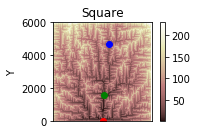

In [10]:
## Plot Square
%matplotlib inline 
map_fig = plt.figure('DEM maps')
ax1 = map_fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(rmg_sq, z_sq,plot_name='Square', color_for_closed="white")  # plot the DEM
plt.plot(rmg_sq.node_x[outlet_node_to_sample_sq],rmg_sq.node_y[outlet_node_to_sample_sq],'ro')
plt.plot(rmg_sq.node_x[midstream_node_to_sample_sq],rmg_sq.node_y[midstream_node_to_sample_sq],'go')
plt.plot(rmg_sq.node_x[upstream_node_to_sample_sq],rmg_sq.node_y[upstream_node_to_sample_sq],'bo')


#KRB note: I'd add a legend and make the plot bigger. 

** 3.3.2 Spring Creek: set thresholds and select the output nodes listed by threshold **

We will identify the nodes for outlet, midstream, and upstream locations for plotting hydrographs using drainge area thresholds for the latter two. Code is written to set the outlet at the node with the largest drainage area. Below we will first identify the outlet node ID, its elevation and drainage area.


In [11]:
outlet_node_to_sample_sc = np.argmax(rmg_sc.at_node['drainage_area'])
print('Outlet Node = ' + str(outlet_node_to_sample_sc) + '; Drainage Area= ' + str(da_sc[outlet_node_to_sample_sc]/1000000) + ' km2; Elev = '+ str(round(z_sc[outlet_node_to_sample_sc],1)) + ' m')

Outlet Node = 55472; Drainage Area= 26.7525 km2; Elev = 1875.3 m


The midstream and upstream node drainge area thresholds can be identified by drainge area ranges in km2. The range used to identify a midstream location should be larger than the range used to identify an upstream location. These internal nodes can be identified by trial using different drainge area values, and plotting the locations selected. After we select the drainage area ranges we will print the node IDs, drainge areas, and elevations of the locations we select and map the locations on the elevation map of the watershed. 

In [12]:
## These values can be change to set drainage area thresholds in km2
midstream_da_upperbound=20
midstream_da_lowerbound=17.5
upstream_da_upperbound=5
upstream_da_lowerbound=3.2

outlet_node_to_sample_sc = np.argmax(rmg_sc.at_node['drainage_area'])
midstream_node_to_sample_sc = np.where(np.logical_and(rmg_sc.at_node['drainage_area']>midstream_da_lowerbound*1000000, rmg_sc.at_node['drainage_area']<midstream_da_upperbound*1000000))[0][0]
upstream_node_to_sample_sc = np.where(np.logical_and(rmg_sc.at_node['drainage_area']>upstream_da_lowerbound*1000000, rmg_sc.at_node['drainage_area']<upstream_da_upperbound*1000000))[0][0]

print('Outlet Node = ' + str(outlet_node_to_sample_sc) + '; Drainage Area= ' + str(da_sc[outlet_node_to_sample_sc]/1000000) + ' km2; Elev = '+ str(round(z_sc[outlet_node_to_sample_sc],1)) + ' m')
print('Midstream Node = ' + str(midstream_node_to_sample_sc) + '; Drainage Area= ' + str(da_sc[midstream_node_to_sample_sc]/1000000) + ' km2; Elev = '+ str(round(z_sc[midstream_node_to_sample_sc],1)) + ' m')
print('Upstream Node = ' + str(upstream_node_to_sample_sc) + '; Drainage Area= ' + str(da_sc[upstream_node_to_sample_sc]/1000000) + ' km2; Elev = '+ str(round(z_sc[upstream_node_to_sample_sc],1)) + ' m')

Outlet Node = 55472; Drainage Area= 26.7525 km2; Elev = 1875.3 m
Midstream Node = 47742; Drainage Area= 18.7497 km2; Elev = 2062.2 m
Upstream Node = 19131; Drainage Area= 3.2094 km2; Elev = 2243.2 m


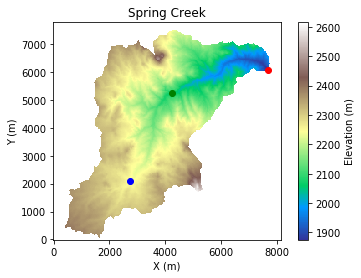

In [13]:
## Plot Spring Creek
ax2 = map_fig.add_subplot(222)
ax2.xaxis.set_visible(False)
imshow_grid(rmg_sc, z_sc,plot_name='Spring Creek',var_name = 'Elevation', var_units = 'm', grid_units = ('m','m'), 
            cmap = 'terrain', limits = (1875, 2615),color_for_closed="white")  # plot the DEM
ax2.set_facecolor("white")
plt.plot(rmg_sc.node_x[outlet_node_to_sample_sc],rmg_sc.node_y[outlet_node_to_sample_sc],'ro')
plt.plot(rmg_sc.node_x[midstream_node_to_sample_sc],rmg_sc.node_y[midstream_node_to_sample_sc],'go')
plt.plot(rmg_sc.node_x[upstream_node_to_sample_sc],rmg_sc.node_y[upstream_node_to_sample_sc],'bo')

# KRB note: Add legend.

__________________
# 4.0. Make Model Decisions 

We used the following runoff categories for this exercise, which can be changed by the user: 
  * `Base` has an intensity of 5.0 mm/hr, with a duration of 2 hr.
  * `HigherIntensity` has an intensity of 10.0 mm/hr, with a duration of 2 hr.
  * `LongerDuration` has an intensity of 5.0 mm/hr, with a duration of 4 hr. Longer duration is hardcoded as twice the storm duration of the base case. However it can be changed.
 
 Below you will indicate the domain, storm category, and algorithm you would like to use. You can change the runoff generation intesity and duration. Note that time is given in hours, and the model is run in *seconds*
 
**Change your model with the options below**

In [21]:
basin_flag = 'Spring Creek'      # 'Square' or 'Spring Creek'
storm_flag = 'HigherIntensity'   # 'Base' or'HigherIntensity' or 'LongerDuration'
routing_method = 'KinwaveImplicitOverlandFlow'  # use 'OverlandFlow' OR 'KinwaveImplicitOverlandFlow'  

Advanced users only: if you know what you are doing, change the options below. 

In [22]:
image_save = 1                   # 1: save image; 0: don't save, this is for animation
hours = 8                        #hours of model run time
Number_frames = 6                    # number of frames to plot
n = 0.03                            # Manning's roughness coefficient, (s/m^(1/3))
Base_runoff_rate = 10               # Base runoff rate (mm/h)
HigherIntesity_runoff_rate = 20     # High intensity runoff rate (mm/h)
Storm_duration = 5                  # Storm duration (hours)
dt = 600                             # time step for KinwaveImplicitOverlandFlow, (s) [i.e., 10 minutes]

______________________
## 5.0  Model Computations

### 5.1. Initialize model run time and output variables used for plotting and animation 

The cell below is designed to set up the model with the decisions made in the cell above. Do not change it unless necessary.

In [23]:
#Convert time
elapsed_time = 1.0   #seconds
model_run_time=hours*3600 #converted to seconds


# Setting up the number of frames to be recorded for creating the animation
ani_inc=np.arange(0, hours, np.true_divide(hours,Number_frames)) #list of timesteps for animation
snap=0   #first snapshot for animation

## Lists for saving data
discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []
hydrograph_time = []

if basin_flag == 'Square':
    watershed_dem = 'Square_TestBasin.asc'
    outlet_node_to_sample = outlet_node_to_sample_sq
    midstream_node_to_sample = midstream_node_to_sample_sq
    upstream_node_to_sample = upstream_node_to_sample_sq
    ### Reading in the DEM given the filename from above
    (rmg, z) = read_esri_ascii(watershed_dem, name='topographic__elevation')
    ## Setting initial fields...
    rmg['node']['surface_water__discharge'] = np.zeros(rmg.number_of_nodes)
    rmg_sq.set_watershed_boundary_condition_outlet_id(outlet_node_to_sample_sq, z_sq,-9999.)

else:
    watershed_dem = 'SpringCreek_DEM.asc'
    outlet_node_to_sample = outlet_node_to_sample_sc
    midstream_node_to_sample = midstream_node_to_sample_sc
    upstream_node_to_sample = upstream_node_to_sample_sc
    ### Reading in the DEM given the filename from above
    (rmg, z) = read_esri_ascii(watershed_dem, name='topographic__elevation')
    ## Setting initial fields...
    rmg['node']['surface_water__discharge'] = np.zeros(rmg.number_of_nodes)
    ## Set boundary coditions on the grid
    rmg.set_watershed_boundary_condition(z)


## instantiate OverlandFlow object
if routing_method == 'OverlandFlow':
    
    of = OverlandFlow(rmg, alpha=0.15, mannings_n = n, steep_slopes = True) 
else: 
    kw = KinwaveImplicitOverlandFlow(rmg, runoff_rate = 0.0, roughness = n, depth_exp = 5/3)
    
## Assign storm conditions based on flag in Code Block 2
if storm_flag == 'Base':
    runoff_mmhr = Base_runoff_rate
    runoff_ms = runoff_mmhr * (2.77778 * 10 ** -7)
    storm_duration = Storm_duration * 3600.
elif storm_flag == 'HigherIntensity':
    runoff_mmhr = HigherIntesity_runoff_rate
    runoff_ms = runoff_mmhr * (2.77778 * 10 ** -7)
    storm_duration = Storm_duration * 3600.
elif storm_flag == 'LongerDuration':
    runoff_mmhr = Base_runoff_rate
    runoff_ms = runoff_mmhr * (2.77778 * 10 ** -7)
    storm_duration = Storm_duration * 2 * 3600.

### 5.2. Run Overland Flow Model 

For each timestep, discharge is calculated at each node.  Using the depth slope product, shear stress is calculated at every node.  Outputs for each node include: water depth, discharge and shear stress values through time at every point in the input grid.  Read more on the [Landlab component description](https://landlab.readthedocs.io/en/release/landlab.components.overland_flow.html) by Jordan Adams. 

elapsed time = 0.0 hours
elapsed time = 1.33 hours
elapsed time = 2.67 hours
elapsed time = 4.0 hours
elapsed time = 5.33 hours
elapsed time = 6.67 hours


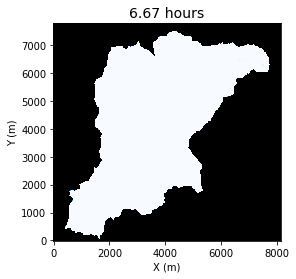

In [24]:
animate_fig = plt.figure()
animation_file_name = str(basin_flag) + '_' + str(storm_flag) + '_' + str(routing_method) + '.mp4'
writer = animation.FFMpegWriter(fps=1)
writer.setup(animate_fig, 'animation.mp4')

while elapsed_time < model_run_time:
    # Setting the adaptive time step
    
    if routing_method == 'OverlandFlow': 
        of.dt = of.calc_time_step()
    
    
    ## The storm starts when the model starts. While the elapsed time is less
    ## than the storm duration, we add water to the system as runoff.
    if routing_method == 'OverlandFlow': 
        
        if elapsed_time < (storm_duration):
            of.rainfall_intensity =  runoff_ms   
        else: # elapsed time exceeds the storm duration, rainfall ceases.
            of.rainfall_intensity = 0.0

    if routing_method == 'OverlandFlow':   
        of.overland_flow() # Generating overland flow based on the deAlmeida solution.
        rmg.at_node['surface_water__discharge'] = of.discharge_mapper(of.q, convert_to_volume=True)
    else:
        if elapsed_time < storm_duration:
            kw.run_one_step(dt, current_time = elapsed_time, runoff_rate = runoff_ms)
        else:
            kw.run_one_step(dt, current_time = elapsed_time, runoff_rate = 0.0)
    

    if routing_method == 'OverlandFlow':
        discharge_at_outlet.append(rmg.at_node['surface_water__discharge'][outlet_node_to_sample])
        discharge_midstream.append(rmg.at_node['surface_water__discharge'][midstream_node_to_sample])
        discharge_upstream.append(rmg.at_node['surface_water__discharge'][upstream_node_to_sample])
    else:
        discharge_at_outlet.append(rmg.at_node['surface_water_inflow__discharge'][outlet_node_to_sample])
        discharge_midstream.append(rmg.at_node['surface_water_inflow__discharge'][midstream_node_to_sample])
        discharge_upstream.append(rmg.at_node['surface_water_inflow__discharge'][upstream_node_to_sample])
    
    
    ## Append time and discharge to their lists to save data and for plotting.
    hydrograph_time.append(round(elapsed_time/3600,2)) #saved in hours

    ## output time every now and then so that you know the code is actually running
    ## each time loop a new image is mapped, this sequence will build the animation
    
    
    if snap < len(ani_inc):
        if (elapsed_time/3600) > ani_inc[snap]:

            print('elapsed time = ' + str(round(elapsed_time/3600,2)) + ' hours')

            imshow_grid(rmg, 'surface_water__depth', colorbar_label='Depth (m)',plot_name = 'Surface Water Depth', 
                    var_name = 'Water Depth', var_units = 'm', grid_units = ('m','m'), 
                    cmap='Blues', limits = (0, 0.5))
            plt.title('{} hours'.format(str(round(elapsed_time/3600,2))),
                    fontsize=14) 

            if image_save == 1:
                plt.savefig(str(basin_flag) + '_' + str(storm_flag) + '_' + str(routing_method) + '_' + str(ani_inc[snap]) + 'hr_map.png', format='png', dpi=2500)

            writer.grab_frame()

            snap +=1

            # Remove the colorbar to reset the figure for the next animation timestep.
            plt.gci().colorbar.remove()
    

    ## Updating elapsed_time
    if routing_method == 'OverlandFlow': 
        elapsed_time += of.dt
    else: 
        elapsed_time += dt
    
    
writer.finish()
from IPython.display import HTML

HTML("""<div align="middle"> <video width="80%" controls loop><source src="animation.mp4" type="video/mp4"> </video></div>""")


For more on animation, see this Landlab animation tutorial see https://github.com/landlab/tutorials/blob/master/plotting/animate-landlab-output.ipynb

## 6.0 Results
In thise section you will start preparing your results for model simulations you ran. You will plot modeled hydrographs at each location in the same figure for the selected study domain. In this plot you will notice differences in the time to peak and peak discharge magnitudes at different locations. You may also notice differences in the results generated by the two methods.  

### 6.1. Plot hydrograph for one model result 

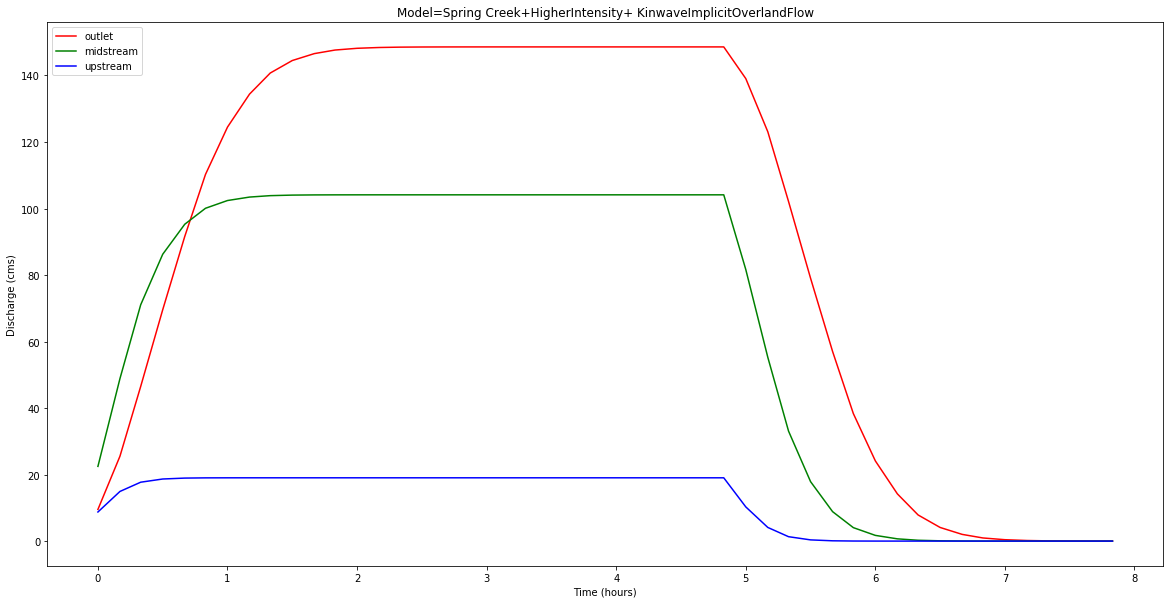

In [25]:
#%matplotlib inline  ## This line controls showing the plot within the Notebook
hydrograph_fig = plt.figure(figsize=(20, 10) )
plt.plot(hydrograph_time, discharge_at_outlet, 'r-', label = 'outlet')
plt.plot(hydrograph_time, discharge_midstream, 'g-', label = 'midstream')
plt.plot(hydrograph_time, discharge_upstream, 'b-', label = 'upstream')
plt.ylabel('Discharge (cms)')
plt.xlabel('Time (hours)')
plt.legend(loc = 'upper left')
title_text = 'Model=' + str(basin_flag) + '+'+ str(storm_flag) + '+ ' + routing_method 
plt.title(title_text)
plt.savefig(basin_flag + '_' + storm_flag + '_' + routing_method + '_hydrograph.png',format ='png',dpi=1000)

### 6.2. Show map for one model result at the time step of interest to you 

List the available image files printed in each model run and animation increment that you would like to view. Note that you will need to change the last line of the code block below to visualize the model run you want to see.

In [26]:
print('The model your have just run will have individual snapshots of the aninimation with this file naming structure --')
#change this shell script below list all file names for a png based on your model (e.g. *png, Spring*png, or Square*png)
!ls Spring*png

The model your have just run will have individual snapshots of the aninimation with this file naming structure --
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_0.0hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_1.33333333333hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_2.66666666667hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_4.0hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_5.33333333333hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_6.66666666667hr_map.png
Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_hydrograph.png


Choose and visualize the image file by changing the name of the image input to be consistent with the name of a image listed above. 

<Figure size 7200x7200 with 0 Axes>

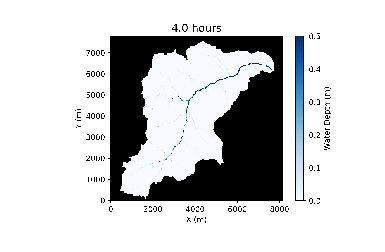

<Figure size 7200x7200 with 0 Axes>

In [29]:
img=mgimg.imread(fname='Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_4.0hr_map.png')
imgplot=plt.imshow(img)
plt.axis('off')
plt.figure(figsize=(100,100))

### 6.3. Save model results into a text file at the end of each model run 

If you want to explore the hydrographs created in this application in another software environment, you will run the code below to create a single .csv file that contains modeled hydrograps at each location in the watershed. Please run this code for each run you completed separately. The .csv file can be used in Excel, Matlab or any other software. The name of the new file will be printed.  

In [ ]:
modeldata=pd.DataFrame()
modeldata['Timestep']=hydrograph_time
modeldata['outlet']=discharge_at_outlet
modeldata['midstream']=discharge_midstream
modeldata['upstream']=discharge_upstream
header={'Timestep','Outlet_cms','Midstream_cms','Upstream_cms'}
modeldata.to_csv(str(basin_flag + '_' + storm_flag + '_' + routing_method  + '_flow.csv'),index=False,header=header,sep=',')

In [ ]:
print('The model your have just run will have individual snapshots of the aninimation with this file naming structure --')
#change this shell script below list all file names for a png based on your model (e.g. *png, Spring*png, or Square*png)
!ls *csv



# KRB note: How do I download this file?


** You completed the tutorial to run the model. You can now explore different routing methods and model parameters  by editing and re-executing sections by making model decisions (4.0), running the model (5.0) and saving results (6.0). Repeat as many model runs as you like and save all of your results before you start comparing results.**  



## 7.0. Discussion 

In this section you will visualize results from your model runs to compare results obtained in the two study watersheds and begin writing your observations from model runs. In this section you may also generate more research questions to explore with the two models. You will also see how two methods can yield different results. 



### 7.1. Plot maps of water depth for two model runs  

Choose two image files printed in each animation increment **from two different models** to compare at a timestep that is most interesting. 


In [ ]:
hydrograph_fig = plt.figure(figsize=(20, 18) )
ax1 = hydrograph_fig.add_subplot(221)
fname1='Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_2.66666666667hr_map.png'
img1=mgimg.imread(fname1)
imgplot=plt.imshow(img1)
ax1.axis('off')

## Plotting the hydrographs from the Spring Creek DEM at the outlet
ax2 = hydrograph_fig.add_subplot(222)
fname2='Spring Creek_HigherIntensity_OverlandFlow_2.66666666667hr_map.png'
img2=mgimg.imread(fname2)
imgplot=plt.imshow(img2)
ax2.axis('off')

# KRB note, I got an error IOError: [Errno 2] No such file or directory: 'Spring Creek_HigherIntensity_OverlandFlow_2.66666666667hr_map.png'


### 7.2. Plot hydrographs for two model runs  

In [ ]:
!ls -lt *_hydrograph.png



In [ ]:
hydrograph_fig = plt.figure(figsize=(20 , 20) )
ax1 = hydrograph_fig.add_subplot(221)
fname1='Spring Creek_HigherIntensity_KinwaveImplicitOverlandFlow_hydrograph.png'
img1=mgimg.imread(fname1)
imgplot=plt.imshow(img1)
ax1.axis('off')

## Plotting the hydrographs from the Spring Creek DEM at the outlet
ax2 = hydrograph_fig.add_subplot(222)
fname2='Spring Creek_HigherIntensity_OverlandFlow_hydrograph.png'
img2=mgimg.imread(fname2)
imgplot=plt.imshow(img2)
ax2.axis('off')

## 8.0. Conclusions

If you have reached this point, you should have produced a plot of three hydrographs from different points on the Spring Creek watershed, produced from overland flow driven by the base storm.

There are six scenarios to explore: two different watersheds and three different storms, if you use the default parameters. If you explore different Manning's roughness values run all six scenarios by systematically changing the *basin_flag* and *storm_flag* in Code Block 2 and rerunning all of the code blocks sequentially. Save the hydrograph plots for each scenario. 

**Directions if you are using this as a laboratory exercise**

Include those plots in a document that also contains your typed answers to each of the questions below. Answer all of the questions with complete sentences. Try to be as specific and as quantitative as you can. (e.g. You can compare times to peak discharge and peak discharge values among the scenarios.) You are encouraged to discuss the results of the models with your classmates, but the text you turn in must be your own thoughts and words.

1. What aspects of the hydrograph change at the outlet as the storm gets longer or more intense? Are there aspects of the outlet hydrograph that are not sensitive to the storm duration or intensity? Do the midstream and upstream hydrographs exhibit the same sensitivity to storm duration and intensity? Explain why.  

2. What are the differences in the hydrograph responce in the outlets of the two watersheds? How does the watershed shape influence the hydrograph shape?

3. Now compare the hydrograph shapes across the three different locations in the watersheds. Compare only between similar points (e.g. mid or upstream locations) and between the same storm characteristics. How does watershed shape affect hydrograph shape? Does it impact all locations in the same manner? Do different storm charactersitics exaggerate the differences between the different watersheds?

4. Now compare the results between the two different watershed. How different are hydrograph characteristics between the square and natural watershed (Spring Creek)?

5. Please compare your answers to the questions you answered before running the models. Do the model results match your intuition? If not, do you think your intuition was wrong, or the model was wrong, or both? Remember, models are helpful for learning but they are highly simplified representations of the real world. Wihtout knowing the details of the model, does it seem like something is missing from your model results?

## 9.0. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.

### 9.1. List files to export to new HydroShare resource
The name of files listed below need to be consistent with what exist in your file directory

In [ ]:
ThisNotebook='explore_routing_tutorial.ipynb' #check name for consistency
modelresults='Square_HigherIntensity_OverlandFlow_flow.csv'
animation='animation.mp4'
hydrograph='Square_HigherIntensity_OverlandFlow_3.0hr_map.png'

files=[ThisNotebook,
       modelresults,
       animation,
       hydrograph]

### 9.2. Generate a new HydroShare resource with Title, Abstract, Keyword and files (listed above). 
The metadata can be edited from HydroShare once the new resource is created.  

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Test Delete'
abstract = 'abstract text '
keywords = ['Landlab', 'routing'] 
rtype = 'genericresource'  

#create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)

## 10.0 Clean up - be a good community data steward - Thank You!
After checking that all of the files you want are saved on HydroShare, use shell scripting from the Notebook to view and delete data.  


In [ ]:
#Print current working directory and make sure you are in the correct directory you want to clean up
!pwd
#List files in directory with date of creation. Check that you don’t need any of these files. 
!ls -lt 

In [ ]:
#Remove all files you created. This will not remove the Notebook you are using now.   
!rm *png
!rm *mp4
!rm *csv
#List everything remaining in the folder - this should be only what you downloaded from HydroShare. Note that all of this will be overwritten the next time you Open With from the HydroShare webpage for this resource, execute the Welcome page, and answer ‘Yes’ to download the data again from HydroShare.  
!ls -lt